In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import nfode
import torch.jit
import random
from datetime import datetime

data = np.load('/home/liyilin/nfode/uq/data_set.npz')
t_data = data['t_data']
x_data = data['x_data']

device = torch.device('cuda:1')
x_data = torch.tensor(x_data, dtype=torch.float32).requires_grad_(True).to(device)
t_data = torch.tensor(t_data, dtype=torch.float32).requires_grad_(True).to(device)

test_data = np.load('/home/liyilin/nfode/uq/data_test.npz')
t_data_test = test_data['t_data']
x_data_test = test_data['x_data']

data = np.load('data_test.npz')
t_data_test = data['t_data']
x_data_test = data['x_data']
x_data_test = torch.tensor(x_data_test, dtype=torch.float32)
t_data_test = torch.tensor(t_data_test, dtype=torch.float32).unsqueeze(1)
x0 = x_data_test[:,0]

input_dim=2
output_dim=2
inner_dim=64
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, inner_dim)
        self.fc2 = nn.Linear(inner_dim, inner_dim)
        self.fc3 = nn.Linear(inner_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

k = 1
n = 1

error_matrix = []
params_matrix = []
epochs_vector = []
time_spent_vector = []
while n <= 300:
    model = ODEModel()
    nfode.initialize_params_uniform(model)
    model, best_real_loss, epoch, time_spent = nfode.train(model, device, t_data, x_data, threshold=0.008, k=n, lr=0.01, milestones=[120], gamma=0.1)
    model.to('cpu')
    if epoch < 600:
        #采集参数
        params, flat_params, param_types, param_shapes = nfode.flatten_params(model)
        params_matrix.append(flat_params)

        #采集测试集误差
        x0 = x_data_test[:,0]
        x_preds_test = nfode.predict(model, t_data_test, x0)
        x_error = x_data_test - x_preds_test.detach().numpy().T
        error_matrix.append(x_error)

        #采集训练用时
        epochs_vector.append(epoch)
        time_spent_vector.append(time_spent)

        x_preds_test = nfode.predict(model, t_data_test, x0)
        x_preds_test = x_preds_test.reshape(2,1000)
        loss_fn = nn.MSELoss()
        test_loss = loss_fn(x_preds_test, x_data_test.T)

        print('best real loss:', best_real_loss, 'test loss:', test_loss.cpu().detach().numpy())

        n += 1

1 10 01:04:39 cuda:1 best real loss: 2.1821978
1 20 01:04:56 cuda:1 best real loss: 1.4769601
1 30 01:05:10 cuda:1 best real loss: 1.4769601
1 40 01:05:25 cuda:1 best real loss: 1.4220505
1 50 01:05:39 cuda:1 best real loss: 1.4203469
1 60 01:05:55 cuda:1 best real loss: 1.4203469
1 70 01:06:10 cuda:1 best real loss: 1.4203469
1 80 01:06:26 cuda:1 best real loss: 1.4203469
1 90 01:06:40 cuda:1 best real loss: 1.4203469
1 100 01:06:55 cuda:1 best real loss: 1.4203469
1 110 01:07:11 cuda:1 best real loss: 0.70187116
1 120 01:07:27 cuda:1 best real loss: 0.70187116
1 130 01:07:42 cuda:1 best real loss: 0.70187116
1 140 01:07:57 cuda:1 best real loss: 0.70187116
1 150 01:08:12 cuda:1 best real loss: 0.70187116
1 160 01:08:27 cuda:1 best real loss: 0.70187116
1 170 01:08:42 cuda:1 best real loss: 0.70187116
1 180 01:08:58 cuda:1 best real loss: 0.70187116
1 190 01:09:12 cuda:1 best real loss: 0.70187116
1 200 01:09:28 cuda:1 best real loss: 0.70187116
1 210 01:09:43 cuda:1 best real loss: 0

/home/liyilin/nfode/uq/nfode.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).requires_grad_(True)
/home/liyilin/nfode/uq/nfode.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_data = torch.tensor(t_data, dtype=torch.float32).unsqueeze(1).requires_grad_(True)


best real loss: 0.0060653593 test loss: 4.5472884
2 10 01:32:57 cuda:1 best real loss: 1.9481041
2 20 01:33:13 cuda:1 best real loss: 1.3837517
2 30 01:33:29 cuda:1 best real loss: 1.3837517


KeyboardInterrupt: 

In [ ]:
params_matrix = np.stack(params_matrix, axis = 0)
error_matrix = np.stack(error_matrix, axis = 2)
epochs_vector = np.array(epochs_vector)
time_spent_vector = np.array(time_spent_vector)

np.save('params_matrix.npy', params_matrix)
np.save('error_matrix.npy', error_matrix)
np.save('epochs_vector.npy', epochs_vector)
np.save('time_spent_vector.npy', time_spent_vector)

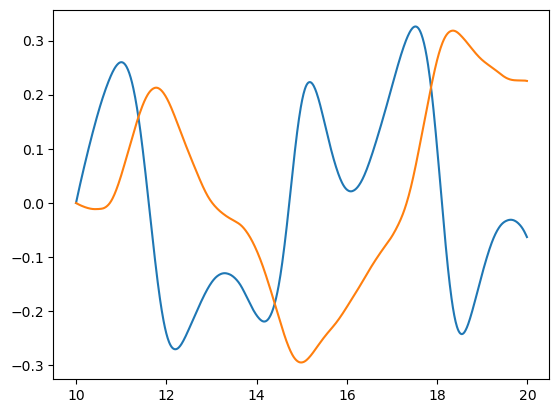

In [ ]:
error_mean = np.mean(error_matrix, axis = 2)

plt.plot(t_data_test, error_mean[0,:])
plt.plot(t_data_test, error_mean[1,:])

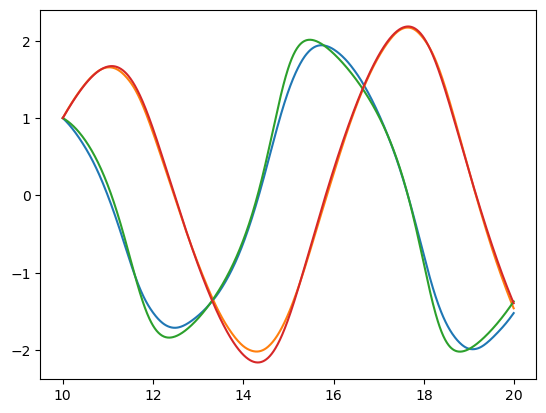

In [ ]:
plt.plot(t_data_test, x_preds_test.reshape(1000,2))
plt.plot(t_data_test, x_data_test.T)

In [ ]:
print(torch.__version__)

2.3.0
